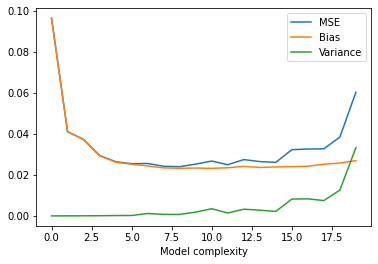

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

RANDOMSTATE = 43

np.random.seed(RANDOMSTATE)

max_degree = 20
datapoints = 50
num_bootstraps = 50
noise = 0.15

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2)) 
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

# Setting up the data
x = np.linspace(0, 1, datapoints)
y = np.linspace(0, 1, datapoints)
x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y)
z += noise * np.random.randn(z.shape[0], z.shape[1])

# Storing the error, variance and bias
error = np.zeros(max_degree)
bias = np.zeros(max_degree)
variance = np.zeros(max_degree)

for degree in range(max_degree):
    X = create_X(x, y, degree)
    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOMSTATE)

    # every row of the matrix is a seperate prediction
    z_pred = np.zeros((z_test.shape[0], num_bootstraps))

    for bootstrap in range(num_bootstraps):
        X_bootstrap, z_bootstrap = resample(X_train, z_train)

        model = LinearRegression().fit(X_bootstrap, z_bootstrap)
        z_pred[:, bootstrap] = model.predict(X_test).flatten()
    
    #calculate errors for each degree
    bias[degree] = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True))**2)
    variance[degree] = np.mean(np.var(z_pred, axis=1, keepdims=True))
    error[degree] = bias[degree] + variance[degree]

fig, ax = plt.subplots()
ax.plot(range(max_degree), error, label='MSE')
ax.plot(range(max_degree), bias, label='Bias')
ax.plot(range(max_degree), variance, label='Variance')
ax.set_xlabel('Model complexity')
ax.legend()